In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import boto3
import mlflow
import pickle
from catboost import CatBoostClassifier
import json

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import ndcg_score
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
)

import scipy
import sys
from implicit.als import AlternatingLeastSquares

pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_columns', 50)  
pd.set_option('display.max_rows', 50)

load_dotenv()

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

ASSETS_DIR = "assets"
if not os.path.exists(ASSETS_DIR):
    os.mkdir(ASSETS_DIR)

DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

MODEL_DIR = "models"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

/home/mle-user/mle_projects/mle-pr-final/last_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Последний столлбец нужно переставить
df = pd.read_parquet(os.path.join(DATA_DIR, "df_clean.parquet"))
cols = df.columns.tolist()
last_col = cols[-1]
cols.remove(last_col)
cols.insert(14, last_col)
df = df[cols]

In [3]:
num_product_cols = len(df.columns[16:])
print(f"Количество продуктовых столбцов: {num_product_cols}")

Количество продуктовых столбцов: 25


In [4]:
df.columns

Index(['fecha_dato', 'ncodpers', 'sexo', 'age', 'fecha_alta', 'ind_nuevo',
       'antiguedad', 'tiprel_1mes', 'indext', 'canal_entrada', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'prod_count', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1',
       'days_since_premium'],
      dtype='object')

In [5]:
# Создаем датафрейм с названиями продуктов и их описанием для удобной интерпретации

product_columns = df.columns[16:40]
products_catalog = pd.DataFrame({
    "product_name": product_columns.tolist(),
    "description": [
        "Сберегательный счёт",
        "Банковская гарантия",
        "Текущие счета",
        "Деривативный счёт",
        "Зарплатный проект",
        "Детский счёт",
        "Особый счёт 3",
        "Особый счёт",
        "Особый счёт 2",
        "Краткосрочный депозит",
        "Среднесрочный депозит",
        "Долгосрочный депозит",
        "Цифровой счёт",
        "Денежные средства",
        "Ипотека",
        "Пенсионный план",
        "Кредит",
        "Налоговый счёт",
        "Кредитная карта",
        "Ценные бумаги",
        "Домашний счёт",
        "Счёт для зарплаты",
        "Счёт для пенсии",
        "Дебетовый счёт"
    ]
})

products_catalog


,product_name,description
0,ind_ahor_fin_ult1,Сберегательный счёт
1,ind_aval_fin_ult1,Банковская гарантия
2,ind_cco_fin_ult1,Текущие счета
3,ind_cder_fin_ult1,Деривативный счёт
4,ind_cno_fin_ult1,Зарплатный проект
5,ind_ctju_fin_ult1,Детский счёт
6,ind_ctma_fin_ult1,Особый счёт 3
7,ind_ctop_fin_ult1,Особый счёт
8,ind_ctpp_fin_ult1,Особый счёт 2
9,ind_deco_fin_ult1,Краткосрочный депозит


In [6]:
products_catalog.to_parquet('data/products_catalog.parquet')

In [7]:
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

products_catalog_parquet = 'final_project/data/products_catalog.parquet'
s3.upload_file(
    os.path.join(DATA_DIR, "products_catalog.parquet"),
    BUCKET_NAME,
    products_catalog_parquet,
)


In [8]:
# Используем отношение длительности владения продуктом к стажу клиента для построения UI-матрицы.
# Значение 1 — максимальная релевантность продукта, 0 — нерелевантность.

# Сортировка по клиенту и дате — ключевой шаг для корректного подсчета
df = df.sort_values(by=["ncodpers", "fecha_dato"]).reset_index(drop=True)

# Проходим по каждому банковскому продукту
for product in products_catalog["product_name"]:
    # Кумулятивная сумма месяцев владения продуктом, сбрасывается, если продукт отключён (0)
    df[f"{product}_cumsum"] = (
        df.groupby(["ncodpers", df[product].eq(0).cumsum()])[product]
        .cumsum()
    )

    # Ранг текущей строки по времени — эквивалент "текущего месяца стажа"
    df[f"{product}_cumsum_rank"] = df.groupby("ncodpers")["fecha_dato"].rank()

    # Нормализация длительности владения на стаж в месяцах
    df[f"{product}_cumsum_ratio"] = (
        df[f"{product}_cumsum"] / df[f"{product}_cumsum_rank"]
    ).round(2)
    
df["prod_count"] = df[product_columns].sum(axis=1)


In [9]:
# Удаляем промежуточные столбцы с кумулятивными значениями и рангами

cols_to_drop = [
    f"{name}_{suffix}"
    for name in products_catalog["product_name"]
    for suffix in ["cumsum", "cumsum_rank"]
]

df.drop(columns=cols_to_drop, inplace=True)


In [10]:
df.to_parquet('data/df.parquet')

In [11]:
df.fecha_dato.describe()

count                         13487872
mean     2015-10-20 11:14:42.672434688
min                2015-01-28 00:00:00
25%                2015-06-28 00:00:00
50%                2015-10-28 00:00:00
75%                2016-02-28 00:00:00
max                2016-05-28 00:00:00
Name: fecha_dato, dtype: object

In [12]:
# Разделим данные на обучающую и тестовую выборки:
# В тест попадают только события последнего месяца (апрель 2016)

split_date = pd.to_datetime("2016-04-28")

# Преобразуем тип даты и определим индексы для train/test
train_idx = pd.to_datetime(df["fecha_dato"]) < split_date

# Разделение на train и test
events_train = df[train_idx].reset_index(drop=True)
events_test = df[~train_idx].reset_index(drop=True)

# Вывод статистики по пользователям и взаимодействиям
print(f"Уникальных пользователей в train: {events_train['ncodpers'].nunique()}")
print(f"Уникальных пользователей в test: {events_test['ncodpers'].nunique()}")
print(f"Количество взаимодействий в train: {len(events_train)}")
print(f"Количество взаимодействий в test: {len(events_test)}")


Уникальных пользователей в train: 931820
Уникальных пользователей в test: 924705
Количество взаимодействий в train: 11644867
Количество взаимодействий в test: 1843005


In [ ]:
events_train.to_parquet('data/events_train.parquet')
events_test.to_parquet('data/events_test.parquet')


: 

In [2]:
df = pd.read_parquet("data/df.parquet")
events_train = pd.read_parquet("data/events_train.parquet")
events_test = pd.read_parquet("data/events_test.parquet")
products_catalog = pd.read_parquet("data/products_catalog.parquet")

In [3]:
# Список колонок с коэффициентами релевантности продуктов
cumsum_ratio_cols = [f"{col}_cumsum_ratio" for col in products_catalog["product_name"]]

In [4]:
# Общие колонки для транзакционной части
trans_cols = ["fecha_dato", "ncodpers", "prod_count"] + products_catalog["product_name"].to_list() + cumsum_ratio_cols

In [5]:
# Выделим транзакционные данные из обучающей и тестовой выборок
events_train_trans = events_train[trans_cols]

In [6]:
events_test_trans = events_test[trans_cols]

In [6]:
events_train_trans

,fecha_dato,ncodpers,prod_count,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1_cumsum_ratio,ind_plan_fin_ult1_cumsum_ratio,ind_pres_fin_ult1_cumsum_ratio,ind_reca_fin_ult1_cumsum_ratio,ind_tjcr_fin_ult1_cumsum_ratio,ind_valo_fin_ult1_cumsum_ratio,ind_viv_fin_ult1_cumsum_ratio,ind_nomina_ult1_cumsum_ratio,ind_nom_pens_ult1_cumsum_ratio,ind_recibo_ult1_cumsum_ratio
0,2015-01-28,15889,4.0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,2015-02-28,15889,3.0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2015-03-28,15889,3.0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2015-04-28,15889,3.0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2015-05-28,15889,4.0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.2,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11644862,2016-03-28,1542658,0.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11644863,2016-03-28,1542659,0.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11644864,2016-03-28,1542660,0.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11644865,2016-03-28,1542661,0.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


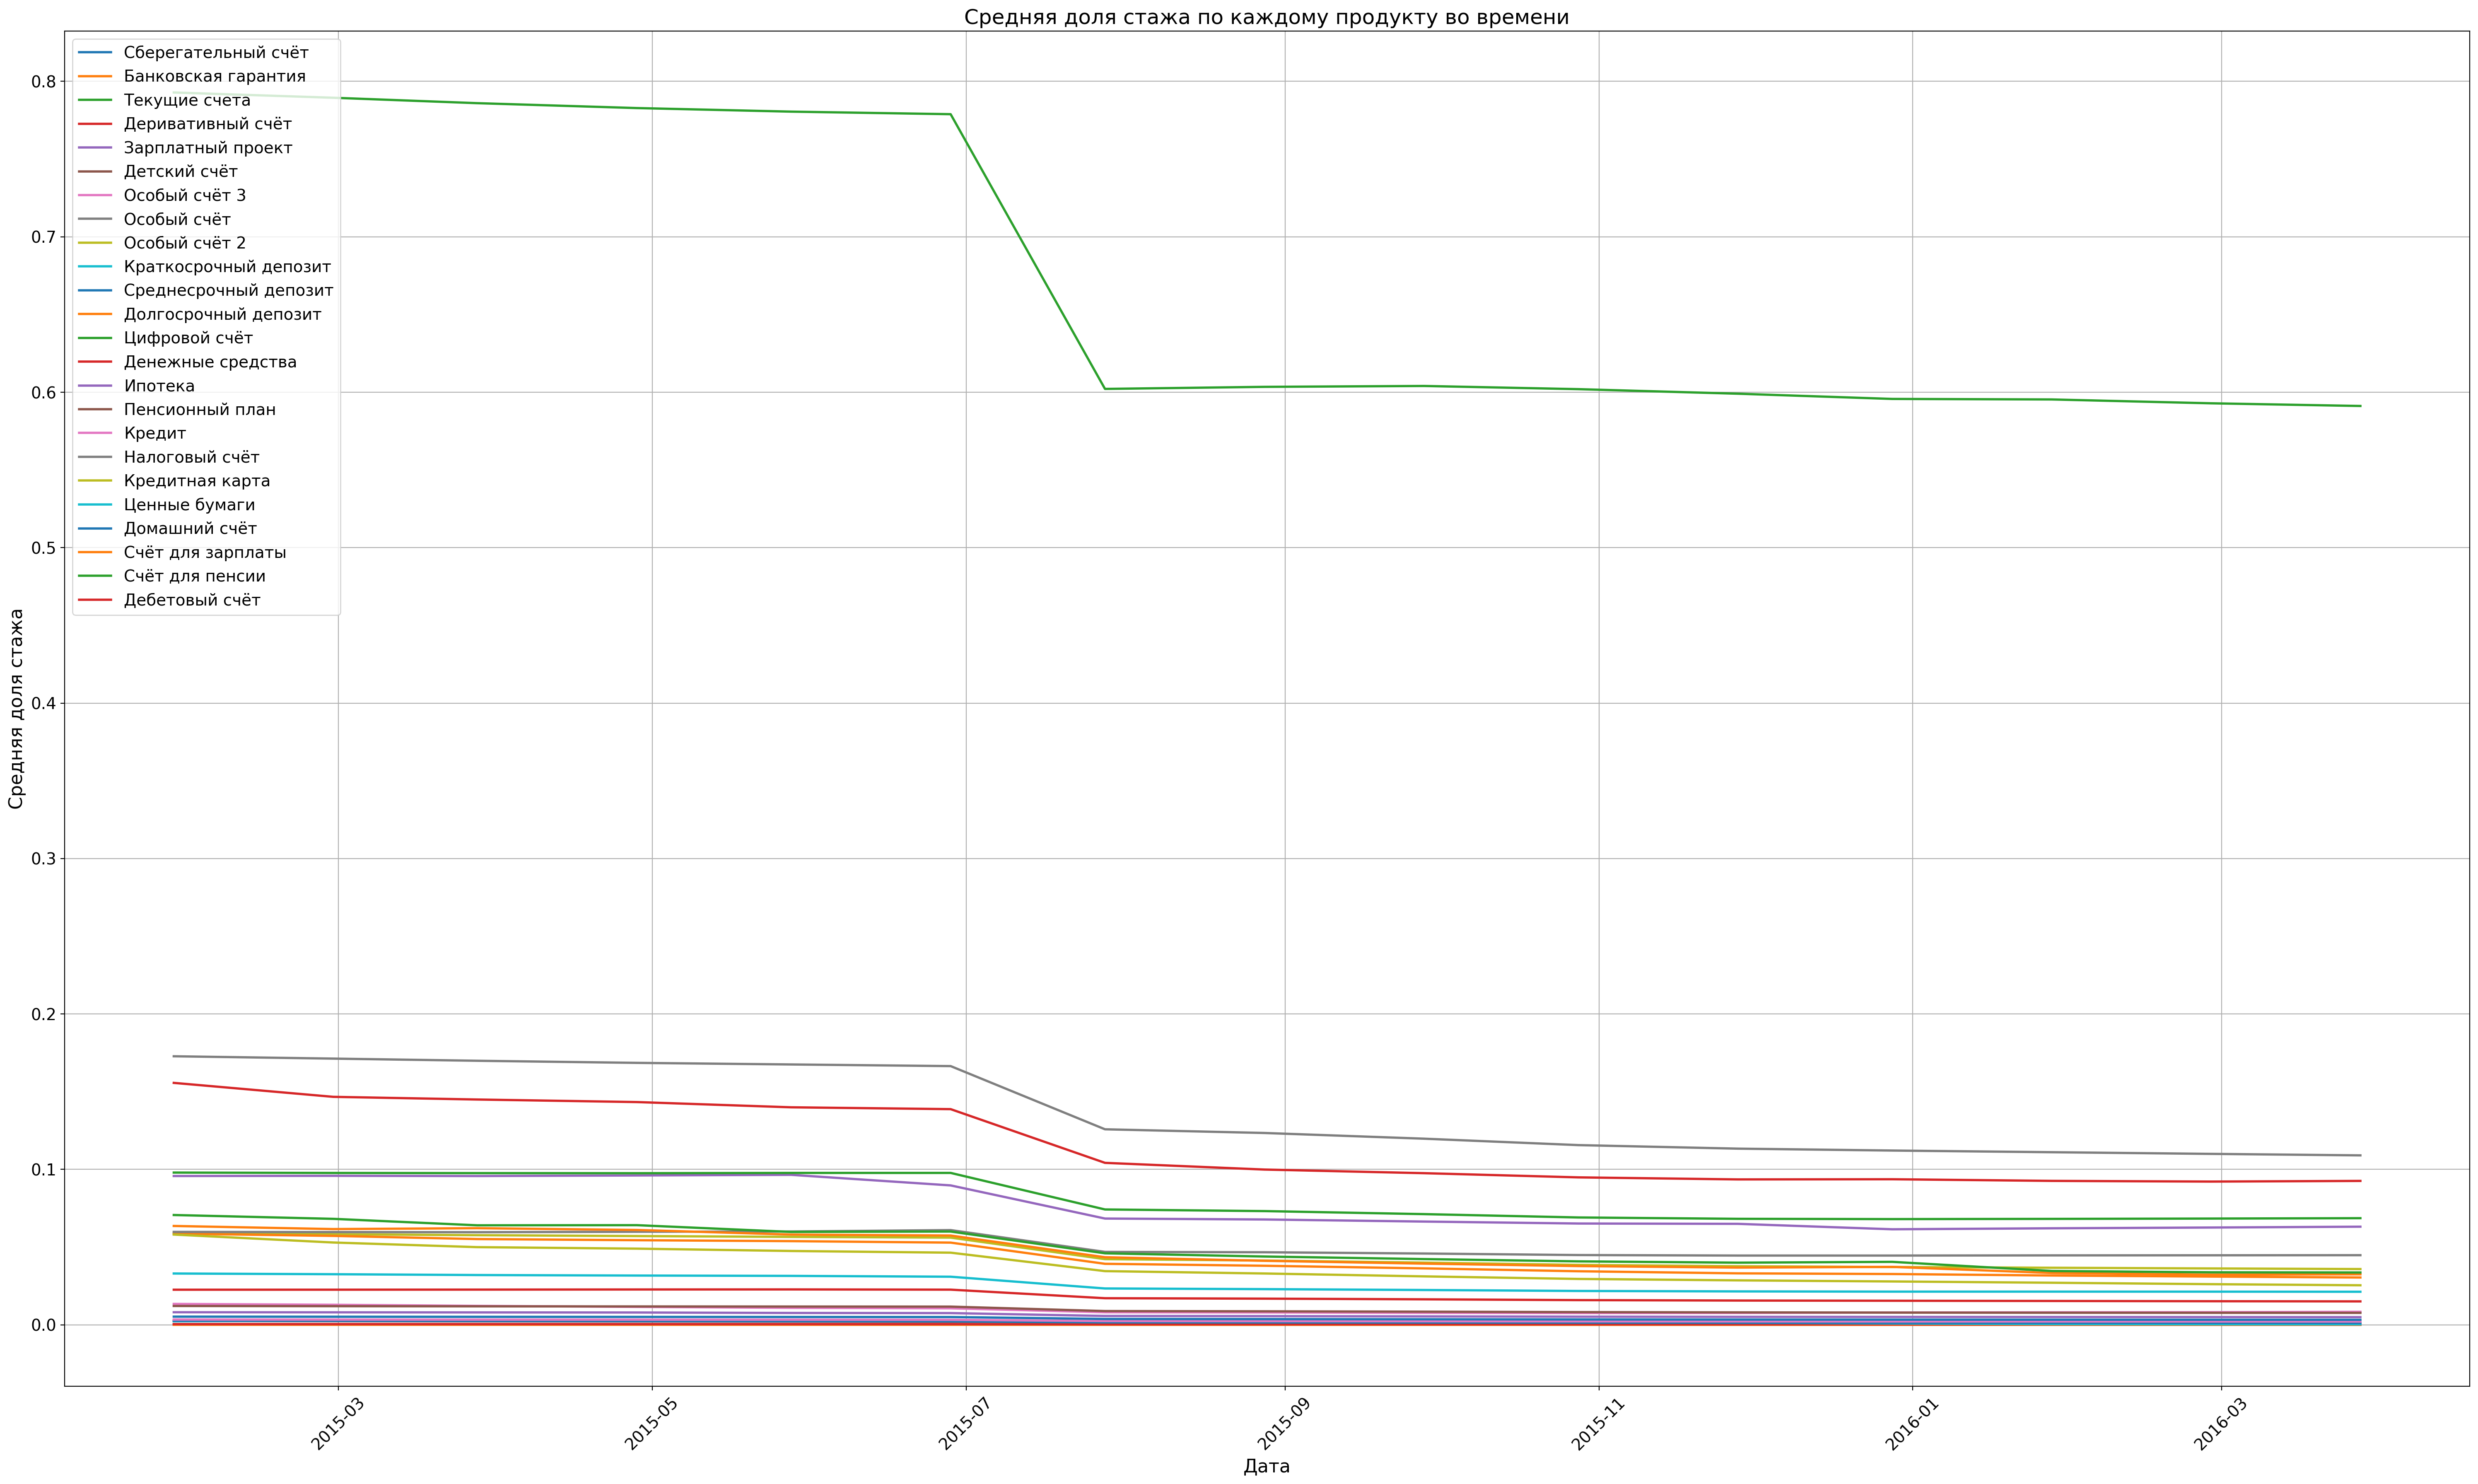

In [7]:
# Визуализация: динамика средней доли стажа по каждому банковскому продукту

# Группировка и расчет среднего значения *_cumsum_ratio по дате
cumsum_ratio_trend = (
    events_train_trans.groupby("fecha_dato")[cumsum_ratio_cols].mean().reset_index()
)

plt.figure(figsize=(30, 18))

for col, label in zip(cumsum_ratio_cols, products_catalog["description"]):
    plt.plot(cumsum_ratio_trend["fecha_dato"], cumsum_ratio_trend[col], label=label, linewidth=2)

plt.legend(loc="upper left", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Средняя доля стажа по каждому продукту во времени", fontsize=18)
plt.ylabel("Средняя доля стажа", fontsize=16)
plt.xlabel("Дата", fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, "product_cumsum_ratio_trends.png"))
plt.show()


In [8]:
# --- Фильтрация и подготовка обучающего и тестового наборов данных ---

# 1. В трейне оставляем только последнюю запись по каждому клиенту
events_train_trans = (
    events_train_trans.drop_duplicates(subset="ncodpers", keep="last")
    .reset_index(drop=True)
)

# 2. Фильтрация: оставляем клиентов с хотя бы одним продуктом в трейне
events_train_trans = events_train_trans[events_train_trans["prod_count"] >= 1].reset_index(drop=True)
print(f"Уникальных пользователей в train с ≥1 продуктом: {len(events_train_trans)}")

# 3. Фильтрация: оставляем клиентов с хотя бы тремя продуктами в тесте
events_test_trans = events_test_trans[events_test_trans["prod_count"] >= 3].reset_index(drop=True)
print(
    f"Уникальных пользователей в test с ≥3 продуктами: "
    f"{events_test_trans['ncodpers'].nunique()}"
)

# 4. Оставляем только ID клиента и фичи *_cumsum_ratio в трейне
events_train_trans = events_train_trans[["ncodpers"] + cumsum_ratio_cols]

# 5. Переименование колонок *_cumsum_ratio на оригинальные имена продуктов
rename_map = dict(zip(cumsum_ratio_cols, products_catalog["product_name"].to_list()))
events_train_trans.rename(columns=rename_map, inplace=True)

# 6. Оставляем те же колонки в тесте
events_test_trans = events_test_trans[["ncodpers"] + cumsum_ratio_cols]
events_test_trans.rename(columns=rename_map, inplace=True)

# 7. Исключаем из теста клиентов, отсутствующих в трейне
events_test_trans = events_test_trans[
    events_test_trans["ncodpers"].isin(events_train_trans["ncodpers"])
].reset_index(drop=True)


Уникальных пользователей в train с ≥1 продуктом: 687179
Уникальных пользователей в test с ≥3 продуктами: 128288


In [9]:
# --- Формируем список уникальных пользователей из train и test ---

user_list = list(set(events_train_trans["ncodpers"]) | set(events_test_trans["ncodpers"]))
print(f"Общее число уникальных пользователей: {len(user_list)}")


Общее число уникальных пользователей: 687179


In [11]:
# --- Перекодируем идентификаторы пользователей в последовательность 0, 1, 2, ... ---
user_encoder = LabelEncoder()
user_encoder.fit(user_list)

events_train_trans["ncodpers_enc"] = user_encoder.transform(events_train_trans["ncodpers"])
events_test_trans["ncodpers_enc"] = user_encoder.transform(events_test_trans["ncodpers"])

# --- Добавим числовой идентификатор для каждого продукта ---
products_catalog = products_catalog.reset_index().rename(columns={"index": "names_enc"})


In [12]:
# Формируем матрицу признаков с индексами - закодированные ID клиентов,
# а колонками - закодированные ID продуктов

events_train_trans_matrix = (
    events_train_trans
    .drop(columns="ncodpers")
    .set_index("ncodpers_enc")
)

events_train_trans_matrix.columns = products_catalog["names_enc"]

events_train_trans_matrix.head()


names_enc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
ncodpers_enc,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.07,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,0.0,0.0,1.0,0.0,0.0,1.00,0.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.47,1.0,0.0,0.0,0.0,0.0,1.0,1.00,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,1.00,1.0,0.0,1.0,1.0,1.0


In [13]:
# Создаем разреженную UI-матрицу в формате CSR из значений датафрейма
user_item_matrix_train = scipy.sparse.csr_matrix(events_train_trans_matrix.values)

# Рассчитываем степень разреженности — долю нулевых элементов в матрице
sparsity = (events_train_trans_matrix == 0).sum().sum() / (events_train_trans_matrix.shape[0] * events_train_trans_matrix.shape[1])
print(f"Степень разреженности UI-матрицы: {sparsity:.4f}")

# Оцениваем размер памяти, занятой данными разреженной матрицы, в гигабайтах
memory_gb = sum(sys.getsizeof(i) for i in user_item_matrix_train.data) / 1024**3
print(f"Требуемый объем памяти для хранения UI-матрицы: {memory_gb:.4f} ГБ")


Степень разреженности UI-матрицы: 0.9257
Требуемый объем памяти для хранения UI-матрицы: 0.0365 ГБ


In [14]:
# Инициализируем ALS-модель с 50 латентными факторами и регуляризацией
als_model = AlternatingLeastSquares(
    factors=50,
    iterations=50,
    regularization=0.05,
    random_state=0,
)

# Обучаем модель на разреженной пользовательско-продуктовой матрице
als_model.fit(user_item_matrix_train)


/home/mle-user/mle_projects/mle-pr-final/last_env/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


In [15]:
def get_recommendations_als(
    user_item_matrix,
    model,
    user_id,
    user_encoder,
    products_catalog,
    include_seen=True,
    n=5,
):
    """
    Возвращает топ-N рекомендованных продуктов для заданного пользователя.
    
    Параметры:
    - user_item_matrix: разреженная матрица взаимодействий пользователей с продуктами
    - model: обученная модель ALS
    - user_id: идентификатор пользователя в исходных данных
    - user_encoder: объект для преобразования user_id в внутренний индекс модели
    - products_catalog: DataFrame с описанием продуктов, содержит 'names_enc' и 'describe'
    - include_seen: если False, исключает продукты, которыми пользователь уже пользуется
    - n: количество рекомендаций
    
    Возвращает:
    - DataFrame с рекомендованными продуктами и их оценками
    """
    # Кодируем user_id для модели
    user_id_enc = user_encoder.transform([user_id])[0]
    
    # Получаем рекомендации от модели
    recommendations = model.recommend(
        user_id_enc,
        user_item_matrix[user_id_enc],
        filter_already_liked_items=not include_seen,
        N=n,
    )
    
    # Формируем DataFrame с рекомендациями и оценками
    recommendations_df = pd.DataFrame({
        "names_enc": recommendations[0],
        "score": recommendations[1]
    })
    
    # Добавляем описание продуктов из каталога
    recommendations_df = recommendations_df.merge(
        products_catalog,
        on="names_enc",
        how="left"
    )
    
    return recommendations_df


In [16]:
ncodpers = 15889

recs = get_recommendations_als(
    user_item_matrix_train,
    als_model,
    ncodpers,
    user_encoder,
    products_catalog,
    include_seen=True,
    n=24,
)

recs

,names_enc,score,product_name,description
0,2,1.001179,ind_cco_fin_ult1,Текущие счета
1,19,0.999950,ind_valo_fin_ult1,Ценные бумаги
2,8,0.999412,ind_ctpp_fin_ult1,Особый счёт 2
3,18,0.952733,ind_tjcr_fin_ult1,Кредитная карта
4,22,0.000909,ind_nom_pens_ult1,Счёт для пенсии
5,13,0.000588,ind_fond_fin_ult1,Денежные средства
6,1,0.000561,ind_aval_fin_ult1,Банковская гарантия
7,21,0.000412,ind_nomina_ult1,Счёт для зарплаты
8,14,0.000372,ind_hip_fin_ult1,Ипотека
9,4,0.000322,ind_cno_fin_ult1,Зарплатный проект


In [17]:
events_test_trans.loc[events_test_trans["ncodpers"] == ncodpers, products_catalog["product_name"].to_list()]

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,1.0,0.0,0.0,0.0,0.0


In [18]:
events_train_trans_matrix

names_enc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
ncodpers_enc,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.07,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,0.0,0.0,1.0,0.0,0.0,1.00,0.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.47,1.0,0.0,0.0,0.0,0.0,1.0,1.00,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,1.00,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687174,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
687175,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
687176,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [19]:
# Проверяем наличие продуктов клиента в train и test, сравниваем со списком рекомендаций

# Берём рекомендации для пользователя (recs),
# объединяем с статусом продуктов в тренировочной матрице (train_status),
# и затем объединяем с данными теста (test_status).

result = (
    recs.merge(
        events_train_trans_matrix.loc[user_encoder.transform([ncodpers])[0]], on="names_enc"
    ).merge(
        events_test_trans[events_test_trans["ncodpers"] == ncodpers][
            products_catalog["product_name"].to_list()
        ].T.reset_index(),
        left_on="product_name",
        right_on="index",
        how="left",
    ).drop(
        columns="index"
    ).set_axis(
        ["names_enc", "als_score", "product_name", "description", "train_status", "test_status", 'del'],
        axis=1,
    ).iloc[:, :-1].head()
)

display(result)


,names_enc,als_score,product_name,description,train_status,test_status
0,2,1.001179,ind_cco_fin_ult1,Текущие счета,1.00,1.0
1,19,0.999950,ind_valo_fin_ult1,Ценные бумаги,1.00,1.0
2,8,0.999412,ind_ctpp_fin_ult1,Особый счёт 2,1.00,1.0
3,18,0.952733,ind_tjcr_fin_ult1,Кредитная карта,0.07,0.0
4,22,0.000909,ind_nom_pens_ult1,Счёт для пенсии,0.00,0.0


In [20]:
# Список всех кодированных пользователей
user_list_encoded = range(len(user_encoder.classes_))

# Получаем по 3 рекомендации для всех клиентов, исключая уже оформленные продукты
als_recommendations = als_model.recommend(
    user_list_encoded,
    user_item_matrix_train[user_list_encoded],
    3,
    filter_already_liked_items=True
)

In [21]:
# Преобразуем рекомендации ALS-модели в табличный формат

# Распаковываем идентификаторы продуктов и оценки рекомендаций
names_enc, als_scores = als_recommendations

# Формируем DataFrame с рекомендациями: один пользователь — несколько продуктов
als_recommendations_df = pd.DataFrame({
    "ncodpers_enc": np.repeat(user_list_encoded, repeats=len(names_enc[0])),
    "names_enc": np.concatenate(names_enc),
    "score": np.concatenate(als_scores),
})

als_recommendations_df.head()


,ncodpers_enc,names_enc,score
0,0,22,0.000909
1,0,13,0.000588
2,0,1,0.000561
3,1,2,0.048061
4,1,13,0.000895


In [22]:
# Приводим типы данных к корректным
als_recommendations_df["names_enc"] = als_recommendations_df["names_enc"].astype(int)
als_recommendations_df["score"] = als_recommendations_df["score"].astype(float)

# Декодируем идентификаторы пользователей
als_recommendations_df["ncodpers"] = user_encoder.inverse_transform(
    als_recommendations_df["ncodpers_enc"]
)

# Присоединяем описание продуктов по кодам
als_recommendations_df = als_recommendations_df.merge(
    products_catalog, on="names_enc", how="left"
)

# Удаляем технические столбцы
als_recommendations_df.drop(columns=["ncodpers_enc", "names_enc"], inplace=True)

als_recommendations_df.head()


,score,ncodpers,product_name,description
0,0.000909,15889,ind_nom_pens_ult1,Счёт для пенсии
1,0.000588,15889,ind_fond_fin_ult1,Денежные средства
2,0.000561,15889,ind_aval_fin_ult1,Банковская гарантия
3,0.048061,15890,ind_cco_fin_ult1,Текущие счета
4,0.000895,15890,ind_fond_fin_ult1,Денежные средства


In [23]:
als_recommendations_df.to_parquet("data/personal_als.parquet")
events_train_trans.to_parquet("data/events_train_trans.parquet")
events_test_trans.to_parquet("data/events_test_trans.parquet")
als_model.save("data/als_model")

In [24]:
# Переструктурируем обучающий набор:
# оставим только активные (релевантные) продукты клиента с ненулевыми оценками

# Сохраняем список названий продуктов
product_names = products_catalog["product_name"].to_list()

# Преобразуем значения по всем продуктам в список и дублируем имена продуктов
events_train_trans["score"] = events_train_trans[product_names].values.tolist()
events_train_trans["product_name"] = [product_names] * len(events_train_trans)

# Преобразуем таблицу в длинный формат: одна строка = один продукт пользователя
events_train_trans = (
    events_train_trans[["ncodpers", "product_name", "score"]]
    .explode(["product_name", "score"])
    .query("score > 0")
    .reset_index(drop=True)
)


In [25]:
# Преобразуем тестовый набор: оставим только активные продукты клиента (со значением > 0)

# Получаем список названий всех продуктов
product_names = products_catalog["product_name"].to_list()

# Преобразуем значения по всем продуктам в списки и дублируем названия продуктов
events_test_trans["score"] = events_test_trans[product_names].values.tolist()
events_test_trans["product_name"] = [product_names] * len(events_test_trans)

# Преобразуем в длинный формат и фильтруем только активные продукты
events_test_trans = (
    events_test_trans[["ncodpers", "product_name", "score"]]
    .explode(["product_name", "score"])
    .query("score > 0")
    .reset_index(drop=True)
)


In [30]:
# Добавим в датафрейм с рекомендациями фактические значения оценок из трейна и теста

# Присоединяем значения из обучающей выборки
als_recommendations = als_recommendations_df.merge(
    events_train_trans[["ncodpers", "product_name", "score"]].rename(columns={"score": "score_train"}),
    on=["ncodpers", "product_name"],
    how="left"
)

# Присоединяем значения из тестовой выборки
als_recommendations = als_recommendations.merge(
    events_test_trans[["ncodpers", "product_name", "score"]].rename(columns={"score": "score_test"}),
    on=["ncodpers", "product_name"],
    how="left"
)


In [31]:
als_recommendations.head()

,score,ncodpers,product_name,description,score_train,score_test
0,0.000909,15889,ind_nom_pens_ult1,Счёт для пенсии,NaN,NaN
1,0.000588,15889,ind_fond_fin_ult1,Денежные средства,NaN,NaN
2,0.000561,15889,ind_aval_fin_ult1,Банковская гарантия,NaN,NaN
3,0.048061,15890,ind_cco_fin_ult1,Текущие счета,NaN,NaN
4,0.000895,15890,ind_fond_fin_ult1,Денежные средства,NaN,NaN


In [34]:
def compute_ndcg(rating: pd.Series, score: pd.Series, k: int) -> float:
    """
    Вычисляет метрику NDCG@k для одного пользователя.

    Параметры:
    - rating: Series с фактическими значениями (целевые метки)
    - score: Series с предсказанными оценками
    - k: количество топ-позиций для оценки

    Возвращает:
    - NDCG@k (float) или np.nan, если недостаточно данных
    """
    if len(rating) < 2:
        return np.nan
    ndcg = ndcg_score(
        np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k
    )
    return ndcg

In [35]:
# Фильтруем рекомендации, где известны истинные оценки из тестовой выборки
rating_test_idx = ~als_recommendations["score_test"].isna()

# Вычисляем NDCG@3 для каждого пользователя
ndcg_at_3_scores = als_recommendations[rating_test_idx].groupby("ncodpers").apply(
    lambda df: compute_ndcg(df["score_test"], df["score"], k=3)
)

# Выводим среднее значение NDCG@3 и количество валидных значений
print(f"NDCG@3 mean: {ndcg_at_3_scores.mean():.4f}")
print(f"Число пользователей с ненулевым NDCG@3: {ndcg_at_3_scores.notna().sum()}")


NDCG@3 mean: 0.9328
Число пользователей с ненулевым NDCG@3: 3107


/tmp/ipykernel_3389/555959313.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_at_3_scores = als_recommendations[rating_test_idx].groupby("ncodpers").apply(


In [36]:
# Проверка 
als_recommendations[als_recommendations["ncodpers"] == 18424]
# Важно отметить, что некоторые продукты, рекомендованные моделью (например, ind_fond_fin_ult1 и ind_ctop_fin_ult1),
# отсутствовали у клиента в обучающей выборке (train_score=0), но появились в тестовом периоде (test_score=1).
# Это означает, что модель успешно предсказала новые приобретённые продукты, что подтверждает её прогностическую силу.

,score,ncodpers,product_name,description,score_train,score_test
3214,0.001026,18424,ind_ctop_fin_ult1,Особый счёт,NaN,NaN
3215,0.000776,18424,ind_ctju_fin_ult1,Детский счёт,NaN,NaN
3216,0.000658,18424,ind_fond_fin_ult1,Денежные средства,NaN,NaN


In [37]:
als_recommendations.to_parquet(os.path.join(DATA_DIR, "personal_als.parquet"))

In [44]:
als_model.save(os.path.join(MODEL_DIR, "als_model"))

In [45]:
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

als_recommendations_parquet = os.environ.get("KEY_PERSONAL_ALS_PARQUET")
s3.upload_file(
    os.path.join(DATA_DIR, "personal_als.parquet"),
    BUCKET_NAME,
    "data/recommendations/",
)

als_model_npz = os.environ.get("KEY_ALS_MODEL")
s3.upload_file(os.path.join(MODEL_DIR, "als_model.npz"), BUCKET_NAME, "model/")

In [47]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [48]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = "final_project"

RUN_NAME = "ALS_recomendation"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("S3_ENDPOINT_URL")
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact(os.path.join(ASSETS_DIR, "product_cumsum_ratio_trends.png"))
    mlflow.log_artifact("recs.ipynb")
    mlflow.log_artifact(os.path.join(DATA_DIR, "products_catalog.parquet"))
    mlflow.log_artifact(os.path.join(DATA_DIR, "events_train_trans.parquet"))
    mlflow.log_artifact(os.path.join(DATA_DIR, "events_test_trans.parquet"))
    mlflow.log_artifact(os.path.join(DATA_DIR, "personal_als.parquet"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "als_model.npz"))
    mlflow.log_artifact("requirements.txt")

🏃 View run ALS_recomendation at: http://127.0.0.1:5000/#/experiments/1/runs/9ed1064bef764c82b253df47dfb8a6e5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [50]:
# Загружаем подготовленные данные
df = pd.read_parquet(os.path.join(DATA_DIR, "df_clean.parquet"))
cols = df.columns.tolist()
last_col = cols[-1]
cols.remove(last_col)
cols.insert(14, last_col)
df = df[cols]
product_columns = df.columns[16:]
df["prod_count"] = df[product_columns].sum(axis=1)

products_catalog = pd.read_parquet(os.path.join(DATA_DIR, "products_catalog.parquet"))

# Удаляем ненужные столбцы, оставляем только последние записи по умолчанию, сбрасываем индекс
df = (
    df.drop(columns=["fecha_dato", "prod_count", "ncodpers", "nomprov"])
      .drop_duplicates(keep="last")
      .reset_index(drop=True)
)

# Приводим к нужному типу данных (int), чтобы избежать потенциальных проблем с типами
# int_columns = ["ind_actividad_cliente", "ind_nuevo", "age", "cod_prov"]
# for col in int_columns:
#     df[col] = df[col].astype(int)

print(f"Размер датафрейма: {df.shape}")


Размер датафрейма: (9551786, 37)


In [51]:
# Определяем категориальные и числовые признаки
cat_cols = [
    "sexo",
    "ind_nuevo",
    "indext",
    "canal_entrada",
    "cod_prov",
    "ind_actividad_cliente",
    "segmento",
]
num_cols = ["age", "antiguedad", "renta"]

# Инициализируем OneHotEncoder с удалением одного бинарного признака для избежания мультиколлинеарности
one_hot_encoder = OneHotEncoder(drop="if_binary", sparse_output=False)
one_hot_encoder.fit(df[cat_cols])

# Инициализируем StandardScaler для числовых признаков
scaler = StandardScaler()
scaler.fit(df[num_cols])

def encode_features(one_hot_encoder, scaler, df, cat_cols, num_cols):
    """
    Кодирует категориальные и числовые признаки с помощью обученных трансформеров.

    Args:
        one_hot_encoder: обученный OneHotEncoder.
        scaler: обученный StandardScaler.
        df: DataFrame с исходными данными.
        cat_cols: список категориальных столбцов.
        num_cols: список числовых столбцов.

    Returns:
        pd.DataFrame с объединёнными отмасштабированными числовыми и кодированными категориальными признаками.
    """
    # Преобразуем категориальные признаки
    cat_encoded = one_hot_encoder.transform(df[cat_cols])
    cat_encoded_df = pd.DataFrame(cat_encoded, columns=one_hot_encoder.get_feature_names_out(cat_cols), index=df.index)

    # Преобразуем числовые признаки
    num_scaled = scaler.transform(df[num_cols])
    num_scaled_df = pd.DataFrame(num_scaled, columns=num_cols, index=df.index)

    # Объединяем в один DataFrame
    return pd.concat([num_scaled_df, cat_encoded_df], axis=1)


In [52]:
# Определяем размеры обучающей и тестовой выборок
train_size = 1_000_000
test_size = 200_000

# Создаем тренировочный и тестовый датасеты
df_train = df.iloc[:train_size].copy()
df_test = df.iloc[train_size : train_size + test_size].copy()

# Освобождаем память, удаляя исходный DataFrame
del df

# Кодируем признаки для тренировочной выборки
drop_res_train = encode_features(one_hot_encoder, scaler, df_train, cat_cols, num_cols)

# Добавляем к закодированным признакам колонки с продуктами из products_catalog
drop_res_train = pd.concat(
    [drop_res_train, df_train[products_catalog["product_name"].to_list()]], axis=1
)

print("train df shape:", drop_res_train.shape)


train df shape: (1000000, 251)


In [54]:
# Обучаем модель KMeans с 8 кластерами (бейзлайн) на признаках без продуктовых колонок
features = drop_res_train.drop(columns=products_catalog["product_name"].to_list()).fillna(0)

kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto")
kmeans.fit(features)

# Добавляем метки кластеров в исходный DataFrame
drop_res_train["labels"] = kmeans.predict(features)


In [55]:
drop_res_train[drop_res_train["labels"] == 1]

,age,antiguedad,renta,sexo_H,sexo_V,sexo_None,ind_nuevo_1.0,indext_S,canal_entrada_004,canal_entrada_007,canal_entrada_013,canal_entrada_025,canal_entrada_K00,canal_entrada_KAA,canal_entrada_KAB,canal_entrada_KAC,canal_entrada_KAD,canal_entrada_KAE,canal_entrada_KAF,canal_entrada_KAG,canal_entrada_KAH,canal_entrada_KAI,canal_entrada_KAJ,canal_entrada_KAK,canal_entrada_KAL,...,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,labels
0,-1.060309,-0.679068,-0.109692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
1,-1.060309,-0.679068,-0.776477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
2,-0.882797,-0.679068,-0.620078,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
3,-0.705286,-0.679068,-0.891413,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,1,1
4,-0.941968,-0.679068,-0.414464,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999746,-0.527775,-0.350027,-1.165845,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1,1
999772,-0.586945,-0.350027,0.542646,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1,1
999907,-0.941968,-0.350027,0.910056,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1
999932,-0.941968,-0.350027,-0.414464,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1,1


In [56]:
# Группируем данные по кластерам и вычисляем среднее значение для каждого продукта в каждом кластере
kmeans_recs = (
    drop_res_train
    .groupby("labels")[products_catalog["product_name"].to_list()]
    .mean()
    .reset_index()
)

kmeans_recs


,labels,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0.000410,0.000179,0.545754,0.001255,0.198633,0.001741,0.009985,0.302071,0.118967,0.001971,0.004993,0.134829,0.201564,0.067401,0.017103,0.038508,0.002458,0.161661,0.155542,0.093428,0.012520,0.128502,0.148026,0.289410
1,1,0.000000,0.000000,0.779268,0.000000,0.048650,0.000038,0.002637,0.003152,0.002097,0.000502,0.000094,0.002492,0.015884,0.000697,0.000006,0.000126,0.000019,0.006172,0.006046,0.000910,0.000031,0.032077,0.032912,0.067454
2,2,0.000149,0.000044,0.496172,0.000369,0.158760,0.000579,0.003327,0.317247,0.085490,0.001580,0.005153,0.099888,0.142255,0.035178,0.015434,0.021561,0.003784,0.098105,0.105708,0.045063,0.008445,0.105139,0.118914,0.217649
3,3,0.000000,0.000000,0.514567,0.000050,0.148513,0.004677,0.041023,0.024431,0.056075,0.016065,0.001707,0.056569,0.130047,0.008484,0.000636,0.003623,0.002217,0.056962,0.059824,0.010835,0.002075,0.098506,0.104875,0.218528
4,4,0.000017,0.000051,0.518867,0.000407,0.134306,0.003097,0.043403,0.019859,0.054988,0.015796,0.001927,0.059481,0.136097,0.015615,0.000949,0.005047,0.003063,0.064533,0.068314,0.020159,0.001599,0.087455,0.092102,0.214019
5,5,0.000000,0.000000,0.774239,0.000016,0.057626,0.000093,0.004019,0.003918,0.002426,0.000855,0.000109,0.003592,0.024739,0.001749,0.000047,0.000218,0.000163,0.011421,0.011180,0.003219,0.000047,0.038435,0.039142,0.094897
6,6,0.000299,0.000011,0.531377,0.001557,0.167972,0.000741,0.000992,0.331412,0.089570,0.001109,0.004261,0.091447,0.150016,0.051822,0.024244,0.025743,0.005397,0.118588,0.134224,0.072147,0.010154,0.109678,0.122751,0.245889
7,7,0.000332,0.000138,0.558276,0.000471,0.143724,0.003379,0.018336,0.142200,0.068774,0.005041,0.002299,0.061461,0.132312,0.036589,0.005678,0.016951,0.001606,0.110791,0.092621,0.054952,0.007118,0.090947,0.100809,0.207429


In [57]:
# Преобразуем агрегированные средние значения в формат "кластер-продукт-рейтинг"
kmeans_recs["score"] = kmeans_recs[products_catalog["product_name"].to_list()].values.tolist()
kmeans_recs["product_name"] = [products_catalog["product_name"].to_list()] * len(kmeans_recs)

# Оставляем только нужные колонки и раскрываем списки в отдельные строки
kmeans_recs = kmeans_recs[["labels", "product_name", "score"]].explode(["score", "product_name"])

# Фильтруем продукты с положительными оценками (используются в кластере)
kmeans_recs = kmeans_recs[kmeans_recs["score"] > 0].reset_index(drop=True)

# Отбираем топ-5 продуктов с наибольшим средним рейтингом для каждого кластера
kmeans_recs = (
    kmeans_recs
    .sort_values(by=["labels", "score"], ascending=[True, False])
    .groupby("labels")
    .head(5)
    .reset_index(drop=True)
)

kmeans_recs


,labels,product_name,score
0,0,ind_cco_fin_ult1,0.545754
1,0,ind_ctop_fin_ult1,0.302071
2,0,ind_recibo_ult1,0.28941
3,0,ind_ecue_fin_ult1,0.201564
4,0,ind_cno_fin_ult1,0.198633
5,1,ind_cco_fin_ult1,0.779268
6,1,ind_recibo_ult1,0.067454
7,1,ind_cno_fin_ult1,0.04865
8,1,ind_nom_pens_ult1,0.032912
9,1,ind_nomina_ult1,0.032077


In [60]:
# Кодируем тестовые данные с помощью тех же трансформеров
drop_res_test = encode_features(one_hot_encoder, scaler, df_test, cat_cols, num_cols)

# Предсказываем кластеры для тестового набора
df_test["labels"] = kmeans.predict(drop_res_test.fillna(0))

# Группируем по кластерам и вычисляем среднее значение по продуктам для теста
kmeans_recs_test = (
    df_test
    .groupby("labels")[products_catalog["product_name"].to_list()]
    .mean()
    .reset_index()
)

kmeans_recs_test


,labels,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0.000327,0.000000,0.558569,0.000735,0.092305,0.002287,0.014377,0.197108,0.143604,0.001062,0.004329,0.103169,0.127757,0.033900,0.005391,0.013478,0.001634,0.087077,0.070413,0.041333,0.006617,0.063143,0.072864,0.141562
1,1,0.000000,0.000000,0.858155,0.000000,0.030873,0.000000,0.002850,0.002690,0.004022,0.000000,0.000080,0.001785,0.015290,0.000719,0.000000,0.000027,0.000000,0.007459,0.004448,0.000986,0.000027,0.018886,0.019445,0.037745
2,2,0.000152,0.000000,0.520722,0.000404,0.078237,0.000202,0.003032,0.264733,0.093854,0.000809,0.003689,0.072223,0.083898,0.017891,0.011725,0.008491,0.004751,0.059588,0.049732,0.020671,0.005559,0.054483,0.063631,0.115132
3,3,0.000000,0.000000,0.485157,0.000108,0.093181,0.004482,0.035924,0.021978,0.130503,0.001685,0.001398,0.054137,0.135487,0.009035,0.000466,0.003693,0.000394,0.056719,0.052667,0.012728,0.002008,0.066973,0.069267,0.142837
4,4,0.000024,0.000073,0.480790,0.000390,0.082742,0.003122,0.039127,0.016905,0.134431,0.001708,0.001537,0.058934,0.144261,0.016295,0.000463,0.004708,0.000878,0.061081,0.057910,0.021710,0.001708,0.054885,0.057836,0.136261
5,5,0.000000,0.000000,0.848927,0.000000,0.037312,0.000000,0.003900,0.003830,0.004638,0.000000,0.000035,0.002494,0.023610,0.001335,0.000035,0.000211,0.000070,0.013386,0.009275,0.003127,0.000000,0.024312,0.024910,0.058216
6,6,0.000357,0.000000,0.551607,0.000911,0.082689,0.000515,0.001030,0.264274,0.080431,0.000713,0.002853,0.061017,0.085859,0.025793,0.015967,0.010103,0.007607,0.075320,0.064860,0.033797,0.006736,0.056064,0.062364,0.130037
7,7,0.000128,0.000000,0.584800,0.000638,0.075108,0.003826,0.016450,0.080337,0.095511,0.001275,0.001658,0.041954,0.094874,0.020275,0.001530,0.006758,0.000638,0.063759,0.046672,0.027416,0.003060,0.048202,0.051007,0.104948


In [61]:
# Добавляем в тестовые рекомендации списки продуктов и их средних значений (score_test)
kmeans_recs_test["score_test"] = kmeans_recs_test[products_catalog["product_name"].to_list()].values.tolist()
kmeans_recs_test["product_name"] = [products_catalog["product_name"].to_list()] * len(kmeans_recs_test)

# Оставляем нужные колонки и раскрываем списки в строки
kmeans_recs_test = kmeans_recs_test[["labels", "product_name", "score_test"]].explode(["score_test", "product_name"])

# Объединяем рекомендации из train и test по кластеру и названию продукта
kmeans_recs = kmeans_recs.merge(kmeans_recs_test, on=["labels", "product_name"], how="left")

kmeans_recs


,labels,product_name,score,score_test
0,0,ind_cco_fin_ult1,0.545754,0.558569
1,0,ind_ctop_fin_ult1,0.302071,0.197108
2,0,ind_recibo_ult1,0.28941,0.141562
3,0,ind_ecue_fin_ult1,0.201564,0.127757
4,0,ind_cno_fin_ult1,0.198633,0.092305
5,1,ind_cco_fin_ult1,0.779268,0.858155
6,1,ind_recibo_ult1,0.067454,0.037745
7,1,ind_cno_fin_ult1,0.04865,0.030873
8,1,ind_nom_pens_ult1,0.032912,0.019445
9,1,ind_nomina_ult1,0.032077,0.018886


In [62]:
def compute_ndcg(rating: pd.Series, score: pd.Series, k: int) -> float:
    """
    Вычисляет NDCG@k для одного клиента.

    Parameters:
        rating (pd.Series): Истинные оценки релевантности (например, покупки).
        score (pd.Series): Предсказанные рейтинги или вероятности.
        k (int): Позиция в ранжировании, до которой считается метрика.

    Returns:
        float: Значение NDCG@k, либо np.nan, если данных недостаточно.
    """
    if len(rating) < 2:
        return np.nan
    ndcg = ndcg_score(
        np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k
    )
    return ndcg

In [63]:
# Фильтруем записи с наличием оценок в тесте
rating_test_idx = kmeans_recs["score_test"].notna()

# Вычисляем NDCG@5 для каждого кластера
ndcg_at_5_scores = (
    kmeans_recs[rating_test_idx]
    .groupby("labels")
    .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=5))
)

# Выводим среднее значение NDCG по кластерам
print(f"Среднее значение NDCG@5 по кластерам: {ndcg_at_5_scores.mean():.4f}")

# Показываем результаты для первых нескольких кластеров
print(ndcg_at_5_scores.head())


Среднее значение NDCG@5 по кластерам: 0.9989
labels
0    1.000000
1    1.000000
2    0.999694
3    0.995869
4    0.998499
dtype: float64


/tmp/ipykernel_3389/1209057035.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=5))


In [64]:
# Сохраняем результаты кластеризации с рекомендациями
kmeans_recs.to_parquet(os.path.join(DATA_DIR, "kmeans_clusters_recs.parquet"))

# Сохраняем модель KMeans
with open(os.path.join(MODEL_DIR, "kmeans_model.pkl"), "wb") as f:
    pickle.dump(kmeans, f)

# Сохраняем OneHotEncoder
with open(os.path.join(MODEL_DIR, "one_hot_drop.pkl"), "wb") as f:
    pickle.dump(one_hot_encoder, f)

# Сохраняем StandardScaler
with open(os.path.join(MODEL_DIR, "standart_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)


In [65]:
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

s3.upload_file(
    os.path.join(DATA_DIR, "kmeans_clusters_recs.parquet"),
    BUCKET_NAME,
    "final_project/data/kmeans_clusters_recs/",
)

s3.upload_file(
    os.path.join(MODEL_DIR, "kmeans_model.pkl"), BUCKET_NAME, 'final_project/models/kmeans_model/'
)

s3.upload_file(
    os.path.join(MODEL_DIR, "one_hot_drop.pkl"), BUCKET_NAME, 'final_project/models/one_hot_drop/'
)

s3.upload_file(
    os.path.join(MODEL_DIR, "standart_scaler.pkl"),
    BUCKET_NAME,
    'final_project/models/standart_scaler/',
)

In [66]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = "final_project"
RUN_NAME = "KMEANS_processing"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("S3_ENDPOINT_URL")
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact("recs.ipynb")
    mlflow.log_artifact(os.path.join(DATA_DIR, "kmeans_clusters_recs.parquet"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "kmeans_model.pkl"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "one_hot_drop.pkl"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "standart_scaler.pkl"))
    mlflow.log_artifact("requirements.txt")

🏃 View run KMEANS_processing at: http://127.0.0.1:5000/#/experiments/1/runs/884a41fe5f5147afbb7084e265222dcf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [2]:
df = pd.read_parquet(os.path.join(DATA_DIR, "df_clean.parquet"))
cols = df.columns.tolist()
last_col = cols[-1]
cols.remove(last_col)
cols.insert(14, last_col)
df = df[cols]
product_columns = df.columns[16:]
df["prod_count"] = df[product_columns].sum(axis=1)

In [3]:
products_catalog = pd.read_parquet(os.path.join(DATA_DIR, "products_catalog.parquet"))

# Сортировка по пользователю и времени
df = df.sort_values(by=["ncodpers", "fecha_dato"]).reset_index(drop=True)

In [4]:
# Считаем агрегаты для каждого продукта
for col in products_catalog["product_name"].to_list():
    # Копим сумму по блокам с началом отсчета от 0
    df[f"{col}_cumsum"] = df.groupby(["ncodpers", df[col].eq(0).cumsum()])[col].cumsum()
    
    # Ранг по дате для клиента
    df[f"{col}_cumsum_rank"] = df.groupby("ncodpers")["fecha_dato"].rank()
    
    # Отношение суммы к рангу — стаж в доле
    df[f"{col}_cumsum_ratio"] = (df[f"{col}_cumsum"] / df[f"{col}_cumsum_rank"]).round(2)

In [6]:
# Удаляем временные столбцы
cumsum_cols = [f"{col}_cumsum" for col in products_catalog["product_name"]]
cumsum_rank_cols = [f"{col}_cumsum_rank" for col in products_catalog["product_name"]]
df.drop(columns=cumsum_cols + cumsum_rank_cols, inplace=True)

In [2]:
df = pd.read_parquet('data/df111.parquet')

In [3]:
# Сортировка обратно по дате
df = df.sort_values(by="fecha_dato").reset_index(drop=True)

In [4]:
# Удаляем лишние колонки и дубликаты
drop_cols = ["fecha_dato", "prod_count", "nomprov"]
df = df.drop(columns=drop_cols).drop_duplicates(keep="last").reset_index(drop=True)

In [5]:
df.to_parquet("data/df111.parquet")

In [6]:
products_catalog = pd.read_parquet('data/products_catalog.parquet')

In [10]:
df = pd.read_parquet("data/df111.parquet")

In [11]:
# Признаки
cat_cols = [
    "sexo", "ind_nuevo", "indext", "canal_entrada",
    "cod_prov", "ind_actividad_cliente", "segmento"
]
num_cols = ["age", "antiguedad", "renta"]
cumsum_ratio_cols = [i + "_cumsum_ratio" for i in products_catalog["product_name"].to_list()]

train_size = 1_000_000
test_size = 200_000

X_train = df[:train_size]
y_train = X_train[products_catalog["product_name"].to_list()]
X_train_agg = X_train[cumsum_ratio_cols]
X_train_users = X_train["ncodpers"]
X_train = X_train[cat_cols + num_cols]

X_test = df[train_size : train_size + test_size].reset_index(drop=True)
y_test = X_test[products_catalog["product_name"].to_list()]
X_test_agg = X_test[cumsum_ratio_cols]
X_test_users = X_test["ncodpers"]
X_test = X_test[cat_cols + num_cols]

d = {}
prod_names = products_catalog["product_name"].to_list()
for i, j in enumerate(cumsum_ratio_cols):
    d[j] = prod_names[i]
X_test_agg.rename(columns=d, inplace=True)

del df


In [15]:
X_train

,sexo,ind_nuevo,indext,canal_entrada,cod_prov,ind_actividad_cliente,segmento,age,antiguedad,renta
0,V,0.0,N,KAT,28.0,1.0,01 - TOP,56,245,326124.90
1,H,0.0,N,KFN,29.0,0.0,02 - PARTICULARES,39,82,93488.46
2,V,0.0,N,KAT,33.0,1.0,01 - TOP,55,186,59650.71
3,V,0.0,N,KFC,28.0,1.0,02 - PARTICULARES,46,186,435419.67
4,V,0.0,N,KFC,37.0,1.0,02 - PARTICULARES,46,186,104985.45
...,...,...,...,...,...,...,...,...,...,...
999995,V,0.0,N,KAT,28.0,1.0,02 - PARTICULARES,30,118,189270.69
999996,H,0.0,N,KEY,31.0,0.0,02 - PARTICULARES,68,158,125082.60
999997,V,0.0,N,KHE,29.0,1.0,03 - UNIVERSITARIO,27,9,145710.99
999998,H,0.0,N,RED,3.0,1.0,02 - PARTICULARES,33,16,53154.78


In [18]:
print(X_train.fillna(0).isnull().sum())
print(y_train.fillna(0).isnull().sum())
   

sexo                     0
ind_nuevo                0
indext                   0
canal_entrada            0
cod_prov                 0
ind_actividad_cliente    0
segmento                 0
age                      0
antiguedad               0
renta                    0
dtype: int64
ind_ahor_fin_ult1    0
ind_aval_fin_ult1    0
ind_cco_fin_ult1     0
ind_cder_fin_ult1    0
ind_cno_fin_ult1     0
ind_ctju_fin_ult1    0
ind_ctma_fin_ult1    0
ind_ctop_fin_ult1    0
ind_ctpp_fin_ult1    0
ind_deco_fin_ult1    0
ind_deme_fin_ult1    0
ind_dela_fin_ult1    0
ind_ecue_fin_ult1    0
ind_fond_fin_ult1    0
ind_hip_fin_ult1     0
ind_plan_fin_ult1    0
ind_pres_fin_ult1    0
ind_reca_fin_ult1    0
ind_tjcr_fin_ult1    0
ind_valo_fin_ult1    0
ind_viv_fin_ult1     0
ind_nomina_ult1      0
ind_nom_pens_ult1    0
ind_recibo_ult1      0
dtype: int64


In [26]:
X_test["cod_prov"] = X_test["cod_prov"].fillna(0).astype(int)
X_test["ind_actividad_cliente"] = X_test["ind_actividad_cliente"].astype(int)
X_test["renta"] = X_test["renta"].fillna(0).astype(int)
X_test["ind_nuevo"] = X_test["ind_nuevo"].astype(int)


In [24]:
# Multi-label classification. Инициализация модели


model = CatBoostClassifier(
    cat_features=cat_cols,
    loss_function="MultiLogloss",
    iterations=10,
    learning_rate=1,
    depth=2,
    verbose=False
)

# Обучение
model.fit(X_train.fillna(0), y_train.fillna(0))

# Сохранение
model.save_model(os.path.join(MODEL_DIR, "mlc_model"))


In [29]:
# Предсказание классов
y_pred = model.predict(X_test.fillna(0))
y_pred = np.array(y_pred)

# Предсказание вероятностей
y_proba = model.predict_proba(X_test.fillna(0))

# Метрики
print("F1 (weighted):", f1_score(y_test, np.array(y_pred), average="weighted"))
print("ROC AUC (weighted):", roc_auc_score(y_test, y_pred, average="weighted"))


F1 (weighted): 0.4087459448572044
ROC AUC (weighted): 0.6206443099539422


In [31]:
# Получаем вероятности предсказания для каждого продукта
y_pred = model.predict_proba(X_test.fillna(0))

# Формируем таблицу с рекомендациями
mlc_recs = pd.DataFrame(y_pred, columns=products_catalog["product_name"].to_list())
mlc_recs = pd.concat([X_test_users, mlc_recs], axis=1)
mlc_recs["score"] = mlc_recs[products_catalog["product_name"].to_list()].values.tolist()
mlc_recs["names"] = [products_catalog["product_name"].to_list()] * len(mlc_recs)
mlc_recs = mlc_recs[["ncodpers", "names", "score"]]
mlc_recs = mlc_recs.explode(["score", "names"])

# Данные для оценки
y_pred_df_agg = pd.concat([X_test_users, X_test_agg], axis=1)
y_pred_df_agg["score_test"] = y_pred_df_agg[
    products_catalog["product_name"].to_list()
].values.tolist()
y_pred_df_agg["names"] = [products_catalog["product_name"].to_list()] * len(y_pred_df_agg)
y_pred_df_agg = y_pred_df_agg[["ncodpers", "names", "score_test"]]
y_pred_df_agg = y_pred_df_agg.explode(["names", "score_test"])

y_pred_df_agg

,ncodpers,names,score_test
0,442989,ind_ahor_fin_ult1,0.0
0,442989,ind_aval_fin_ult1,0.0
0,442989,ind_cco_fin_ult1,0.0
0,442989,ind_cder_fin_ult1,0.0
0,442989,ind_cno_fin_ult1,0.0
...,...,...,...
199999,233964,ind_valo_fin_ult1,0.0
199999,233964,ind_viv_fin_ult1,0.0
199999,233964,ind_nomina_ult1,0.0
199999,233964,ind_nom_pens_ult1,0.0


In [32]:
# Оставляем ТОП-5 продуктов по агрегированной метке (score_test) для каждого пользователя
y_pred_df_agg = y_pred_df_agg.sort_values(
    by=["ncodpers", "score_test"], ascending=[True, False]
).reset_index(drop=True)
y_pred_df_agg = y_pred_df_agg.groupby("ncodpers").head(5).reset_index(drop=True)

# Объединяем рекомендации модели с топовыми продуктами из агрегатов
mlc_recs = mlc_recs.merge(y_pred_df_agg, on=["ncodpers", "names"], how="left")
mlc_recs


,ncodpers,names,score,score_test
0,442989,ind_ahor_fin_ult1,0.000133,0.0
1,442989,ind_aval_fin_ult1,0.000057,0.0
2,442989,ind_cco_fin_ult1,0.320709,0.0
3,442989,ind_cder_fin_ult1,0.000605,0.0
4,442989,ind_cno_fin_ult1,0.007486,NaN
...,...,...,...,...
4799995,233964,ind_valo_fin_ult1,0.009017,NaN
4799996,233964,ind_viv_fin_ult1,0.004299,NaN
4799997,233964,ind_nomina_ult1,0.011348,NaN
4799998,233964,ind_nom_pens_ult1,0.010355,NaN


In [33]:
mlc_recs.dropna(subset=['score', 'score_test'])

,ncodpers,names,score,score_test
0,442989,ind_ahor_fin_ult1,0.000133,0.0
1,442989,ind_aval_fin_ult1,0.000057,0.0
2,442989,ind_cco_fin_ult1,0.320709,0.0
3,442989,ind_cder_fin_ult1,0.000605,0.0
7,442989,ind_ctop_fin_ult1,0.255268,1.0
...,...,...,...,...
4799976,233964,ind_ahor_fin_ult1,0.000183,0.0
4799977,233964,ind_aval_fin_ult1,0.00006,0.0
4799978,233964,ind_cco_fin_ult1,0.291084,0.0
4799979,233964,ind_cder_fin_ult1,0.000719,0.0


In [34]:
def compute_ndcg(rating: pd.Series, score: pd.Series, k: int) -> float:
    """
    Вычисляет метрику NDCG@k для одного пользователя.
    
    rating : pd.Series
        Истинные значения релевантности (например, 0 или 1).
    score : pd.Series
        Предсказанные моделью оценки (например, вероятности).
    k : int
        Число топ-N рекомендаций, по которым считается метрика.

    return : float
        Значение метрики NDCG@k. Если данных недостаточно, возвращается np.nan.
    """
    if rating.nunique() <= 1:
        # Недостаточно разнообразия для вычисления NDCG
        return np.nan
    
    return ndcg_score(
        y_true=np.asarray([rating.to_numpy()]),
        y_score=np.asarray([score.to_numpy()]),
        k=k
    )


In [35]:
# Фильтруем строки с ненулевыми значениями рейтингов в тесте
rating_test_idx = ~mlc_recs["score_test"].isnull()

# Группируем по пользователям и вычисляем NDCG@3 для каждого
ndcg_at_3_scores = (
    mlc_recs[rating_test_idx]
    .groupby("ncodpers")
    .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=3))
)

# Выводим среднее значение метрики и количество пользователей с валидным NDCG
print(f"NDCG@3 mean: {ndcg_at_3_scores.mean():.6f}")
print(f"Количество пользователей с валидным NDCG@3: {ndcg_at_3_scores.notna().sum()}")


NDCG@3 mean: 0.937622
Количество пользователей с валидным NDCG@3: 142128


/tmp/ipykernel_2155/3566342344.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_ndcg(x["score_test"], x["score"], k=3))


In [37]:
# Предсказываем вероятности продуктов для объединенного набора train + test
y_pred = model.predict_proba(pd.concat([X_train.fillna(0), X_test.fillna(0)], axis=0))

# Объединяем соответствующие пользователи
y_pred_users = pd.concat([X_train_users, X_test_users], axis=0).reset_index(drop=True)

# Формируем DataFrame с вероятностями по продуктам
mlc_recs = pd.DataFrame(y_pred, columns=products_catalog["product_name"].to_list())

# Добавляем колонку с пользователями
mlc_recs = pd.concat([y_pred_users, mlc_recs], axis=1)

# Преобразуем вероятности в списки для удобного развертывания
mlc_recs["score"] = mlc_recs[products_catalog["product_name"].to_list()].values.tolist()

# Колонка с названиями продуктов для каждого пользователя
mlc_recs["names"] = [products_catalog["product_name"].to_list()] * len(mlc_recs)

# Оставляем только необходимые колонки и разворачиваем списки в строки
mlc_recs = mlc_recs[["ncodpers", "names", "score"]].explode(["score", "names"])

# Удаляем возможные дубликаты (одинаковые пользователь-продукт)
mlc_recs = mlc_recs.drop_duplicates(subset=["ncodpers", "names"]).reset_index(drop=True)

# Сортируем рекомендации по пользователям и убыванию вероятности
mlc_recs = mlc_recs.sort_values(by=["ncodpers", "score"], ascending=[True, False]).reset_index(drop=True)

# Оставляем топ-5 рекомендаций на пользователя
mlc_recs = mlc_recs.groupby("ncodpers").head(5).reset_index(drop=True)

mlc_recs


,ncodpers,names,score
0,15889,ind_ecue_fin_ult1,0.591658
1,15889,ind_recibo_ult1,0.579332
2,15889,ind_dela_fin_ult1,0.568423
3,15889,ind_cco_fin_ult1,0.566741
4,15889,ind_cno_fin_ult1,0.492881
...,...,...,...
4009715,1423452,ind_cco_fin_ult1,0.282963
4009716,1423452,ind_deco_fin_ult1,0.195114
4009717,1423452,ind_ctma_fin_ult1,0.068132
4009718,1423452,ind_ecue_fin_ult1,0.014832


In [38]:
mlc_recs.to_parquet(os.path.join(DATA_DIR, "mlc_recs.parquet"))
model.save_model(os.path.join(MODEL_DIR, "mlc_model"))

In [39]:
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
S3_SERVICE_NAME = "s3"
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL")
BUCKET_NAME = os.environ.get("S3_BUCKET_NAME")

session = boto3.session.Session()

s3 = session.client(
    service_name=S3_SERVICE_NAME,
    endpoint_url=S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
)

s3.upload_file(
    os.path.join(DATA_DIR, "mlc_recs.parquet"),
    BUCKET_NAME,
    "final_project/data/",
)

s3.upload_file(os.path.join(MODEL_DIR, "mlc_model"), BUCKET_NAME, "final_project/models/mlc_model/")

In [44]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = "final_project"

RUN_NAME = "MLC_processing_1"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("S3_ENDPOINT_URL")
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact("recs.ipynb")
    mlflow.log_artifact(os.path.join(DATA_DIR, "mlc_recs.parquet"))
    mlflow.log_artifact(os.path.join(MODEL_DIR, "mlc_model"))
    mlflow.log_artifact("requirements.txt")

🏃 View run MLC_processing_1 at: http://127.0.0.1:5000/#/experiments/1/runs/5b42b739dbe84ea5bf9429ea460f4986
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
